# Advanced Machine Learning: Assignment 3

Nome e cognome: Confalonieri Riccardo <br>
Matricola: 830404<br>
E-mail: r.confalonieri5@campus.unimib.it

## MNIST predictions
<p align = 'justify'>
Implement a neural network for image classification with up to 6000 trainable parameters. In particular, evaluate the classification for the MNIST dataset. 
<p/>

### Import packages

In [1]:
# for model
from tensorflow import keras

# for data visualization and manipulation
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# for splitting data
from sklearn.model_selection import train_test_split

# drive to get the .html file
from google.colab import drive

# For evaluating classification 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

### MNIST dataset
Carico il dataset MNIST e visualizzo alcune informazioni di base riguardanti il dataset.

In [ ]:
# loading data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [5]:
# printing basic info
print('Tipo delle immagini:', type(x_train))
print('Numero di esempi di training:', x_train.shape[0])
print('Numero di label per il training:', y_train.shape[0])
print("Dimensione dell'immagine: " + str(x_train.shape[1]) + "x" + str(x_train.shape[2]))
print("Range di valori dell'immagine ["+ str(x_train.min()) + "," 
      + str(x_train.max()) + "]")
print("Tipo dei valori dell'immagine: ", type(x_train[0,10,12]))
print('Numero di esempi di test:', x_test.shape[0])

Tipo delle immagini: <class 'numpy.ndarray'>
Numero di esempi di training: 60000
Numero di label per il training: 60000
Dimensione dell'immagine: 28x28
Range di valori dell'immagine [0,255]
Tipo dei valori dell'immagine:  <class 'numpy.uint8'>
Numero di esempi di test: 10000


<p align='justify'>
Il dataset caricato di contiene 14000 esempi di immagini, ogni immagine ha una grandezza 28x28 che però è riportata in due dimensioni diverse. 
Inoltre i valori sono nel range $[0, 255]$ e sono di tipo intero, per i modelli neurali occorrerà quindi <i>gestire sia la dimensione dell'array sia convertire i valori in float</i> con range $[0, 1]$. <br>
Visualizzo quindi tutte le possibili classe di appartenenza presenti nel dataset. <br>
</p>


#### Check Y label
<p align='justify'>
Verifico che i valori delle label siano coerenti e quindi compresi nel range $[0,9]$. Verifico inoltre che non ci sia un forte sbilanciamento tra le varie classi.
</p>

In [6]:
print("Le label assumono i seguenti valori:", set(y_train))

# get the total number of labels
n_labels = len(set(y_train))

Le label assumono i seguenti valori: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


<p align='justify'>
Le classi risultano essere nel range corretto, effettuerò però la conversione in one-hot encoding invece di mantenere dei numeri interi.
</p>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


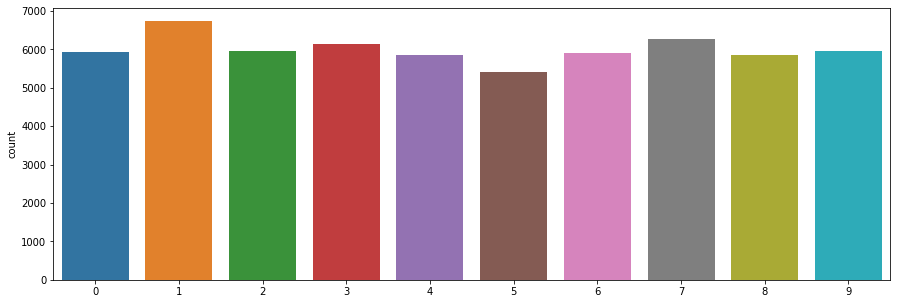

In [7]:
plt.figure(figsize = (15,5))
sns.countplot(y_train)
plt.show()

<p align='justify'>
Il grafico non evidenzia sbilanciamenti notevoli tra i diversi numeri.
</p>

#### Preprocessing
<p align='justify'>
In questa sezione mi occuperò di gestire le problematiche evidenziate dall'analisi del dataset in modo da ottenere un ''nuovo'' dataset pronto per essere passato al modello neurale. In particolare si effettuaranno i seguenti preprocessing:


1.   Conversione dei valori in float e nell'intervallo $[0,1]$
2.   Modifica della shape del dataset da due a tre dimensioni per renderlo coerente con quanto servirà nei layers del modello.
3.   One-hot encoding delle label (non obbligatorio per il modello).
</p>

<p align='justify'>
In particolare tutte queste operazioni verranno effettuate sia sul training che sul test set, in modo da effettuare gli stesssi passaggi ed avere un test set coerente ed utilizzabile una volta trainato il modello. <br>
Inoltre si procederà a <i>splittare il dataset</i> di training per ottenere una piccola porzione di validation utile per valutare i modelli creati. In questo modo utilizzerò il test set già a disposizione come se non conoscessi le corrispondenti label, così da poter provare ad effettuare una predizione e verificare i risultati in maniera indipendente (il validation è comunque utilizzato in fase di training e quindi potrebbe avere un'accuratezza diversa da quella reale su nuovi dati).
</p>

In [8]:
# scaling to float in [0,1]
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

# check result
print("Tipo dei valori dell'immagine: ", type(x_train[0,10,12]))

Tipo dei valori dell'immagine:  <class 'numpy.float32'>


In [9]:
# image reshaping

# I add a dummy dimension, it is necessary for convolutional layers that
# want 4 dimensions in input (batch x height x width x Nchannels) 
x_train = np.expand_dims(x_train, axis = -1)
x_test= np.expand_dims(x_test, axis = -1)

# check result
print("Dimensione dell'immagine: " + str(x_train.shape[1]) + "x" + 
      str(x_train.shape[2]) + "x" + str(x_train.shape[3]))

Dimensione dell'immagine: 28x28x1


In [10]:
# one hot encoding
yc_train = keras.utils.to_categorical(y_train, n_labels)
yc_test = keras.utils.to_categorical(y_test, n_labels)

# check result
print(y_train[0], "to ->", yc_train[0])

5 to -> [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [11]:
# splitting the training set in order to get a validation set
x_train, x_val, y_train, y_val = train_test_split(x_train, yc_train, 
                                                  test_size = 0.1,
                                                  # for replicability
                                                  random_state=99)

#### Neural network
Definisco la neural network per il task di classificazione seguendo le specifiche date per l'assignment. Riporto in questa sezione anche due funzioni utili che permettono di plottare l'andamento della storia del traning e di calcolare delle metriche sulle previsioni e visualizzarle.

In [12]:
# function to visualize the training model history
def plot_history(network_history):
    plt.figure(figsize = (10, 6))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    # rearange the x-axis values
    plt.xticks(np.arange(len(history_mnist.epoch)), np.arange(1, len(history_mnist.epoch)+1))
    plt.title('model loss')
    plt.plot(network_history.history['loss'], marker='.')
    plt.plot(network_history.history['val_loss'], marker='.')
    plt.legend(['Training', 'Validation'])

    plt.figure(figsize = (10, 6))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(len(history_mnist.epoch)), np.arange(1, len(history_mnist.epoch)+1))
    plt.title('model accuracy')
    plt.plot(network_history.history['accuracy'], marker='.')
    plt.plot(network_history.history['val_accuracy'], marker='.')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

In [13]:
# Function that allows you to compute and graphically view some
# accuracy metrics on predictions
def evaluate_predition_ffnn(model, x_test, y_test):

  # prediction for test set
  y_hat = model.predict(x_test)
  # get the label correspoinding to the top score
  y_hat = y_hat.argmax(axis=1)

  # Convert one-hot encoding to integer value
  y_test = y_test.argmax(axis = 1)

  # get the confusion matrix
  cm = confusion_matrix(y_test, y_hat)

  # get and visualize the classification report
  cl = classification_report(y_test, y_hat) 
  print('\nClassification Report\n', cl)

  # plot beautiful confusion matrix
  ax = plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', cmap="YlGnBu");  

  ax.set_xlabel('True labels'); ax.set_ylabel('Predicted labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(range(0,10)); 
  ax.yaxis.set_ticklabels(range(0,10));

  return y_hat, cl

In [14]:
# Sequential model
model = keras.Sequential()

# input layer
model.add(keras.Input(x_train.shape[1:]))
# Convolutional layer 2D with 32 filters 3x3
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation = "relu"))
# Maxpooling layer with 2x2 filter
model.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=2))

# Convolutional layer 2D with 4 filters 2x2
model.add(keras.layers.Conv2D(filters=4, kernel_size=(2, 2), activation = "relu"))
# Maxpooling layer with 3x3 filter and strides = 3
model.add(keras.layers.MaxPool2D(pool_size=(3, 3), strides=3))

# flattening -> loosing spatial dimension of images
model.add(keras.layers.Flatten())
# FC layer with 32 neurons
model.add(keras.layers.Dense(32, activation='relu'))
# Output layer with 10 neurons (number of possible classes)
model.add(keras.layers.Dense(n_labels, activation='softmax'))

# optimization
model.compile(optimizer = "adam", loss = "categorical_crossentropy", 
              metrics = ["accuracy"])

In [15]:
# checking max trainable parameters
print("Numero di parametri del modello:", model.count_params())

Numero di parametri del modello: 3246


In [16]:
# for a more complex report
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 4)         516       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 4)          0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)               

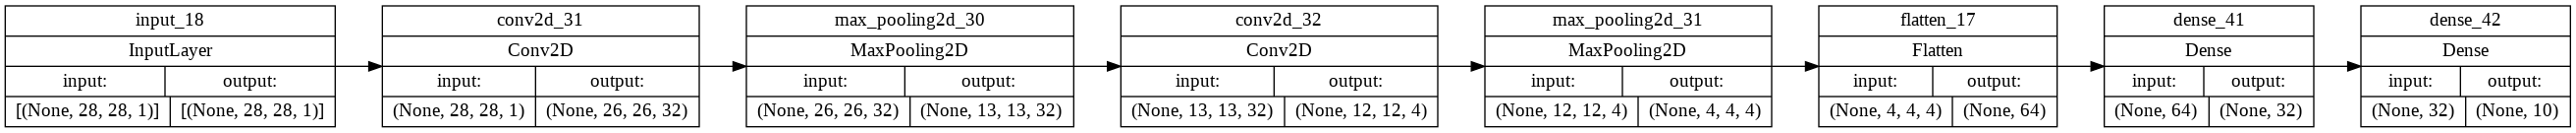

In [ ]:
keras.utils.plot_model(model, rankdir='LR', show_shapes=True)

<p align='justify'>
Traino il modello appena definito, utilizzo anche lo shuffling dei dati anche se il dataset sembra già contenere le immagini dei numeri in maniera randomica. 
</p>

In [ ]:
# add early stopping, stop the model if for 2 epochs the performance get worse 
# and restore the best weights
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, 
                                               patience=2, min_delta = 0.001, 
                                               mode='min', 
                                               restore_best_weights=True)

# training the model on training set + validation set
history_mnist = model.fit(x_train, y_train, epochs = 20, 
                          batch_size = 128, verbose = 1, 
                          shuffle = True,
                          validation_data=(x_val, y_val),
                          callbacks = [early_stopping])

Epoch 1/20
422/422 [==============================] - 5s 10ms/step - loss: 0.7855 - accuracy: 0.7454 - val_loss: 0.2459 - val_accuracy: 0.9242
Epoch 2/20
422/422 [==============================] - 4s 9ms/step - loss: 0.1997 - accuracy: 0.9389 - val_loss: 0.1697 - val_accuracy: 0.9467
Epoch 3/20
422/422 [==============================] - 4s 9ms/step - loss: 0.1498 - accuracy: 0.9535 - val_loss: 0.1347 - val_accuracy: 0.9577
Epoch 4/20
422/422 [==============================] - 4s 9ms/step - loss: 0.1254 - accuracy: 0.9616 - val_loss: 0.1292 - val_accuracy: 0.9618
Epoch 5/20
422/422 [==============================] - 4s 9ms/step - loss: 0.1101 - accuracy: 0.9652 - val_loss: 0.1109 - val_accuracy: 0.9677
Epoch 6/20
422/422 [==============================] - 4s 9ms/step - loss: 0.0982 - accuracy: 0.9690 - val_loss: 0.1054 - val_accuracy: 0.9685
Epoch 7/20
422/422 [==============================] - 4s 9ms/step - loss: 0.0887 - accuracy: 0.9717 - val_loss: 0.0993 - val_accuracy: 0.9718
Epoch

In [ ]:
# print some basic info
print("Numero di epoche totali:", len(history_mnist.epoch))
print("Epoca migliore (weights restored):", (early_stopping.best_epoch+1))
print("Accuracy training set all'epoca", (early_stopping.best_epoch+1), ":", 
      history_mnist.history['accuracy'][early_stopping.best_epoch])
print("Accuracy validation set all'epoca", (early_stopping.best_epoch+1), ":", 
      history_mnist.history['val_accuracy'][early_stopping.best_epoch])
print("Loss training set all'epoca", (early_stopping.best_epoch+1), ":", 
      history_mnist.history['loss'][early_stopping.best_epoch])
print("Loss validation set all'epoca", (early_stopping.best_epoch+1), ":", 
      history_mnist.history['val_loss'][early_stopping.best_epoch])

Numero di epoche totali: 16
Epoca migliore (weights restored): 14
Accuracy training set all'epoca 14 : 0.9813148379325867
Accuracy validation set all'epoca 14 : 0.9791666865348816
Loss training set all'epoca 14 : 0.05820408836007118
Loss validation set all'epoca 14 : 0.07133360207080841


<p align='justify'>
Dalle analisi si evidenzia che l'early stopping ha stoppato il traning del modello dopo $16$ epoche rispetto alle $20$ massime previste ripristinando i pesi individuati all'epoca $14$. <br>
</p>

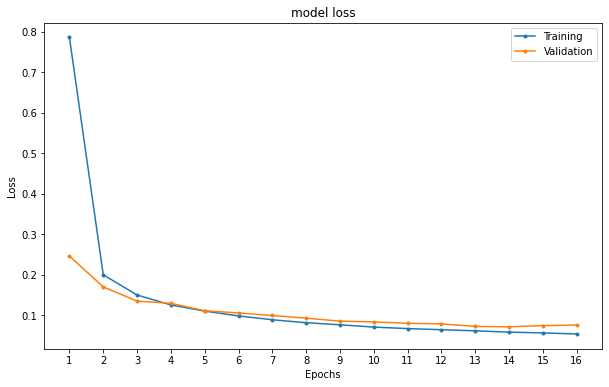

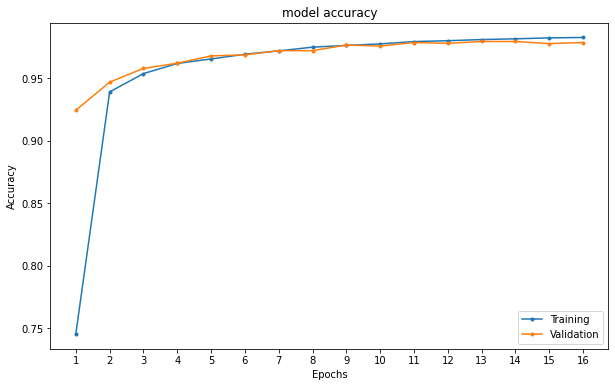

In [ ]:
# checking model history for possible overfitting/underfitting
plot_history(history_mnist)

<p align='justify'>
Il grafico conferma che l'introduzione della tecnica di early stopping è stata molto utile in quanto a partire dall'epoca $14$ si nota come la loss dal training e la loss di validation inizino leggermente a divergere e segnalare una possibile problematica di overfitting. Inoltre anche l'accuracy dopo tale epoca inizia a peggiorare. 
</p>

#### MINST prediction
<p align='justify'>
Dato che prima avevo appositamente riservato il test set per provare a fare delle predizioni su dati mai visti provo ad utilizzare il modello appena fittato e verificarne nuovamente le performance.
</p>


Classification Report
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.96      0.97      1032
           3       0.97      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.99      0.99       892
           6       0.99      0.97      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.97      0.99      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



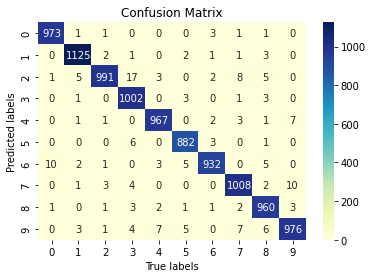

In [ ]:
# evaluate model performance on unseen data
_,_ = evaluate_predition_ffnn(model, x_test, yc_test)

<p align='justify'>
Le performance risultano essere molto buone su tutte le label raggiungendo uno score complessivo di $0.98$. Si segnalano però gli errori maggiori che avvengono nella classificazione dei numeri $2, 6, 7$ che vengono erroneamente classificati rispettivamente come $3, 0,9$. Si segnala anche la casistica del numero $9$ che viene erroneamente classificato con un pò tutti gli altri numeri. <br>
Questo test evidenzia però che, se presente, <i> l'overfitting del training set è davvero minimale</i>.
</p>

In [ ]:
# saving the model
# model.save("model_trained.h5")

### Final considerations 
<p align='justify'>
Durante l'impementazione sono state provate diverse configurazioni che considerassero: 

*    Il numero e il tipo di layer utilizzati
*     I parametri del modello
*    La funzione di ottimizzazione del modello

Queste diverse configurazioni portavano circa allo stesso risultato richiedendo però un numero di epoche notevolmente maggiore (es: funzione di ottimizzazione sgd o adadelta) oppure un numero di parametri trainabili maggiore, anche se minore di $6000$ come richiesto dall'esercizio. 
</p>

In [17]:
# saving .html file

# get drive
# mount personal gdrive folder
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
# download notebook in .html extension
%%shell
jupyter nbconvert --to html '/content/drive/MyDrive/Colab Notebooks/AML/Assignment/Assignment3/Assignment3.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/AML/Assignment/Assignment3/Assignment3.ipynb to html
[NbConvertApp] Writing 447728 bytes to /content/drive/MyDrive/Colab Notebooks/AML/Assignment/Assignment3/Assignment3.html
